In [1]:
import os
import sys
import math
import itertools
import json
import glob
from datetime import datetime
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from data_handling import (
    load_measurements_npz,
    load_state_npz,
    MeasurementDataset,
    MeasurementLoader
)

# Define paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Dict, Any

class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        # Note: Weights learn to accommodate the scale of +/-1 inputs automatically.
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)


class SymmetricRBMBipolar(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        # Weights now connect v (+/-1) to h (0/1)
        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)
        self.initialize_weights()

    def initialize_weights(self):
        # Slightly smaller std dev often helps with bipolar inputs
        nn.init.normal_(self.W, std=0.01)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    # ==========================================================
    #  Helpers: The Adapter Layer
    # ==========================================================
    def _to_spin(self, v_binary: torch.Tensor) -> torch.Tensor:
        """ 0/1 -> -1/+1 """
        return 2.0 * v_binary - 1.0

    def _to_binary(self, v_spin: torch.Tensor) -> torch.Tensor:
        """ -1/+1 -> 0/1 """
        return 0.5 * (v_spin + 1.0)

    # ==========================================================
    #  Conditioning
    # ==========================================================
    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    # ==========================================================
    #  Symmetrized Free Energy (Internal +/- 1)
    # ==========================================================
    def _free_energy(self, v_binary: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        """
        Computes -T * log( exp(-E(v)) + exp(-E(-v)) )
        Using internal spin representation v_s in {-1, 1}.

        E(v_s, h) = -v_s^T b - h^T c - v_s^T W h
        Free Energy F(v_s) = -v_s^T b - sum_j Softplus(c_j + v_s^T W_j)
        """
        v_s = self._to_spin(v_binary) # Convert to spin

        # Linear projections
        # field_h = c + v^T W
        field_h_pos = c_mod + (v_s @ self.W)
        field_h_neg = c_mod - (v_s @ self.W) # E(-v) implies -v^T W = -(v^T W)

        # Visible bias term: -v^T b
        # For E(-v), this becomes -(-v)^T b = +v^T b
        bias_term = (v_s * b_mod).sum(dim=-1)

        # F(v) = -bias_term - sum(softplus(field_pos))
        F_pos = -bias_term - F.softplus(field_h_pos).sum(dim=-1)

        # F(-v) = +bias_term - sum(softplus(field_neg))
        F_neg =  bias_term - F.softplus(field_h_neg).sum(dim=-1)

        # Symmetrize
        stacked = torch.stack([-F_pos, -F_neg], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    # ==========================================================
    #  Gibbs Updates (Internal +/- 1)
    # ==========================================================
    def _sample_h_given_v(self, v_spin: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        # Standard RBM hidden activation: sigmoid(c + vW)
        # Note: v_spin is +/- 1
        p_h = torch.sigmoid((v_spin @ self.W + c_mod) / self.T)
        return torch.bernoulli(p_h, generator=rng)

    def _sample_v_given_h(self, h: torch.Tensor, b_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        """
        Sample visible units v in {-1, 1}.
        Local field at v_i is: b_i + (W h)_i

        P(v_i = +1) = sigmoid( 2 * field / T )
        """
        field = b_mod + (h @ self.W.t())

        # Factor of 2 comes from difference between (+1*field) and (-1*field)
        p_plus1 = torch.sigmoid(2.0 * field / self.T)

        samples_01 = torch.bernoulli(p_plus1, generator=rng)
        return self._to_spin(samples_01)

    def _sample_s_given_v_h(self, v_spin: torch.Tensor, h: torch.Tensor, b_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        """
        Sample s0 (keep) vs s1 (flip).

        Delta E = E(-v, h) - E(v, h)

        In +/- 1 notation:
          E(v)  = -v^T (b + Wh) - h^T c
          E(-v) = +v^T (b + Wh) - h^T c

        dE = 2 * v^T (b + Wh)
        """
        # Recompute total field on v (reuse if optimizing further, but fast enough)
        # field = b + Wh
        field = b_mod + (h @ self.W.t())

        # dE = 2 * v . field
        dE = 2.0 * (v_spin * field).sum(dim=-1)

        # p(s=0 | ...) corresponds to NO flip (keeping v)
        # We want probability that E(v) is the lower energy
        # p(keep) = sigmoid( (E_flip - E_keep) / T ) = sigmoid( dE / T )
        p_keep = torch.sigmoid(dE / self.T)

        return torch.bernoulli(p_keep, generator=rng).unsqueeze(-1)

    def _gibbs_step_sym(self, v_spin: torch.Tensor, h: torch.Tensor, s0: torch.Tensor,
                        b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):

        # 1. Effective v based on previous s
        # If s0=1 (keep), v_eff = v
        # If s0=0 (flip), v_eff = -v
        # In +/- 1 math, this is just multiplication by (2*s0 - 1)
        flipper = (2.0 * s0 - 1.0)
        v_eff = v_spin * flipper

        # 2. Sample h ~ P(h | v_eff)
        h = self._sample_h_given_v(v_eff, c_mod, rng)

        # 3. Sample s ~ P(s | v, h)
        # We check if the 'base' v (v_spin) fits better than -v_spin
        s0 = self._sample_s_given_v_h(v_spin, h, b_mod, rng)

        # 4. Sample v_eff ~ P(v | h)
        v_new_eff = self._sample_v_given_h(h, b_mod, rng)

        # 5. Map back to 'base' v_spin based on the NEW s0
        # If we selected 'keep' (s0=1), v_next = v_new_eff
        # If we selected 'flip' (s0=0), v_next = -v_new_eff
        flipper_new = (2.0 * s0 - 1.0)
        v_next = v_new_eff * flipper_new

        return v_next, h, s0

    # ==========================================================
    #  Public Interface (0/1 In, 0/1 Out)
    # ==========================================================
    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        # v is 0/1, passed directly to helper which converts it
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)
        rng = aux_vars.get("rng")

        b_mod, c_mod = self._compute_effective_biases(cond)

        # Initialize in 0/1
        v_model_01 = v_data.clone()

        # Noise injection (0/1)
        n_noise = int(v_data.shape[0] * aux_vars.get("noise_frac", 0.1))
        if n_noise > 0:
            v_model_01[:n_noise] = torch.bernoulli(
                torch.full_like(v_model_01[:n_noise], 0.5), generator=rng
            )

        # CONVERT TO SPIN DOMAIN
        v_spin = self._to_spin(v_model_01)

        B = v_spin.size(0)
        # s0 in {0,1} (logic variable)
        s0 = torch.bernoulli(torch.full((B, 1), 0.5, device=v_spin.device), generator=rng)
        h = torch.zeros((B, self.num_hidden), device=v_spin.device, dtype=v_spin.dtype)

        # Run Gibbs in Spin Domain
        for _ in range(self.k):
            v_spin, h, s0 = self._gibbs_step_sym(v_spin, h, s0, b_mod, c_mod, rng)

        # CONVERT BACK TO 0/1 DOMAIN
        v_model = self._to_binary(v_spin).detach()

        # Loss calculation uses the internal converters
        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        loss = fe_data.mean() - fe_model.mean()

        return loss, {}

    # Backward compatibility helper
    @torch.no_grad()
    def get_normalized_wavefunction(self, cond: torch.Tensor, all_states: torch.Tensor) -> torch.Tensor:
        if cond.dim() == 1:
            cond = cond.unsqueeze(0)
        cond_exp = cond.expand(all_states.shape[0], -1)

        old_T = self.T
        self.T = 1.0
        log_psi = self.log_score(all_states, cond_exp)
        self.T = old_T

        log_norm_sq = torch.logsumexp(2.0 * log_psi, dim=0)
        return torch.exp(log_psi - 0.5 * log_norm_sq)

In [3]:
def get_sigmoid_curve(high, low, steps, falloff):
    center = steps / 2.0
    def fn(step):
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center))))
    return fn

def train(model, optimizer, loader, num_epochs, rng, lr_schedule_fn):
    global_step = 0
    model.train()
    training_noise_frac = 0.1

    print(f"{'Epoch':<6} | {'Loss':<10} | {'LR':<10}")
    print("-" * 30)

    for epoch in range(num_epochs):
        tot_loss = 0.0
        for batch in loader:
            lr = lr_schedule_fn(global_step)
            for g in optimizer.param_groups: g["lr"] = lr

            optimizer.zero_grad(set_to_none=True)
            loss, _ = model(batch, {"rng": rng, "noise_frac": training_noise_frac})
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            global_step += 1

        if (epoch + 1) % 10 == 0:
            print(f"{epoch+1:<6} | {tot_loss/len(loader):+.4f}     | {lr:.6f}")

    return model

def generate_all_states(num_qubits: int, device: torch.device):
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_overlap(model, h_val, gt_path, all_states):
    psi_np, _ = load_state_npz(gt_path)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    psi_true = psi_true / torch.norm(psi_true) # ensure GT is normalized (just to be safe)

    cond = torch.tensor([h_val], device=device, dtype=torch.float32)
    psi_model = model.get_normalized_wavefunction(cond, all_states)

    return torch.abs(torch.dot(psi_true, psi_model)).item()

In [4]:
GEN_SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 5_000_000
TRAIN_SAMPLE_COUNT = 20_000
N_EPOCHS = 50

# load support and novel points (make sure they exist)
h_support = [1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 5.00]
h_novel   = [1.80, 2.80, 3.20, 4.20]
all_h_values = sorted(list(set(h_support + h_novel)))

file_names = [f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

missing = [fp for fp in file_paths if not fp.exists()]
if missing:
    raise FileNotFoundError(f"Missing data files: {missing}. Please run generation first.")

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)


print(f"Training on {TRAIN_SAMPLE_COUNT} samples per point.")
print(f"Support points: {h_support}")

ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [TRAIN_SAMPLE_COUNT]*len(file_paths))
loader = MeasurementLoader(ds, batch_size=1024, shuffle=True, drop_last=False, rng=rng)

model = ConditionalRBM(ds.num_qubits, num_hidden=64, cond_dim=1, conditioner_width=64, k=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = get_sigmoid_curve(1e-2, 1e-4, N_EPOCHS*len(loader), 0.005)

print("\nStarting Training...")
model = train(model, optimizer, loader, N_EPOCHS, rng, scheduler)

# evaluate overlap with ground truth states
print("\nEvaluating Overlap...")
all_states = generate_all_states(GEN_SIDE_LENGTH**2, device)

results = []
for h_val in all_h_values:
    gt_path = state_dir / f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h_val:.2f}.npz"
    if gt_path.exists():
        ov = compute_overlap(model, h_val, gt_path, all_states)
        rtype = "support" if h_val in h_support else "novel"
        results.append({"h": h_val, "overlap": ov, "type": rtype})
        print(f"h={h_val:.2f} ({rtype:7}) | Overlap = {ov:.5f}")

print("\nFinished.")

Training on 20000 samples per point.
Support points: [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]

Starting Training...
Epoch  | Loss       | LR        
------------------------------
10     | +0.0048     | 0.010000
20     | +0.0065     | 0.009809
30     | -0.0100     | 0.000293
40     | +0.0047     | 0.000100
50     | -0.0086     | 0.000100

Evaluating Overlap...
h=1.00 (support) | Overlap = 0.99975
h=1.50 (support) | Overlap = 0.99955
h=1.80 (novel  ) | Overlap = 0.99920
h=2.00 (support) | Overlap = 0.99882
h=2.50 (support) | Overlap = 0.99777
h=2.80 (novel  ) | Overlap = 0.99762
h=3.00 (support) | Overlap = 0.99770
h=3.20 (novel  ) | Overlap = 0.99787
h=3.50 (support) | Overlap = 0.99807
h=4.00 (support) | Overlap = 0.99835
h=5.00 (support) | Overlap = 0.99868

Finished.


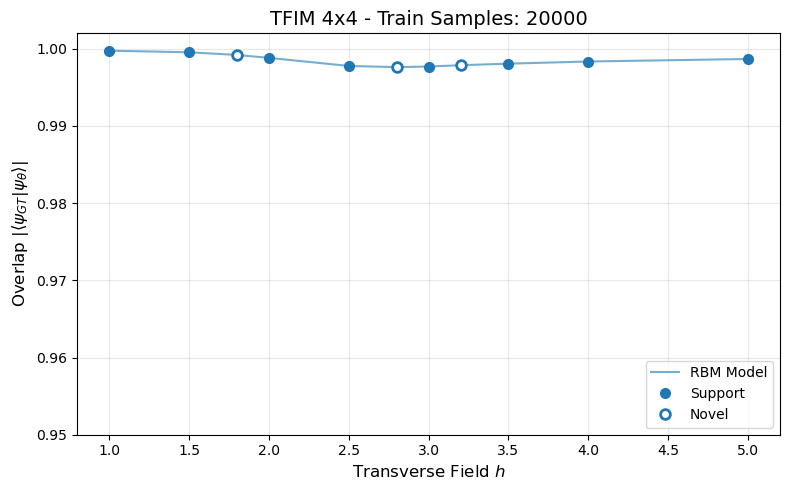

In [7]:
df = pd.DataFrame(results)
supp = df[df["type"] == "support"]
nov  = df[df["type"] == "novel"]

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(df["h"], df["overlap"], '-', color='tab:blue', alpha=0.6, label="RBM Model")
plt.plot(supp["h"], supp["overlap"], 'o', color='tab:blue', markersize=7, label="Support")
plt.plot(nov["h"], nov["overlap"], 'o', color='tab:blue', markerfacecolor='white', markeredgewidth=2, markersize=7, label="Novel")

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_{GT} | \psi_{\theta} \rangle|$", fontsize=12)
plt.title(f"TFIM 4x4 - Train Samples: {TRAIN_SAMPLE_COUNT}", fontsize=14)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [8]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"crbm_tfim_4x4_{TRAIN_SAMPLE_COUNT}_suscept_{timestamp}.pt"
save_path = models_dir / filename

save_dict = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "config": {
        "num_visible": model.num_visible,
        "num_hidden": model.num_hidden,
        "k_steps": model.k,
        "train_samples": TRAIN_SAMPLE_COUNT,
        "epochs": N_EPOCHS,
        "h_support": h_support
    },
    "results": results
}

torch.save(save_dict, save_path)
print(f"Model saved successfully to:\n{save_path.resolve()}")

Model saved successfully to:
/Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_polish/tfim_4x4_new/models/crbm_tfim_4x4_20000_suscept_20251215_215050.pt
